<a href="https://colab.research.google.com/github/o93/bayesian-ab/blob/main/BeyesianCategory_PyMC3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 準備

In [100]:
!pip install pymc3
!pip install japanize-matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


サンプリング




サマリー


,総数,選択数,割合,HDI下限値,HDI上限値
選択1,185,25,0.135135,0.094229,0.175910
選択2,185,45,0.243243,0.193014,0.294498
選択3,185,31,0.167568,0.123202,0.212239
選択4,185,78,0.421622,0.356801,0.475274
選択5,185,6,0.032432,0.014735,0.057880




誤差


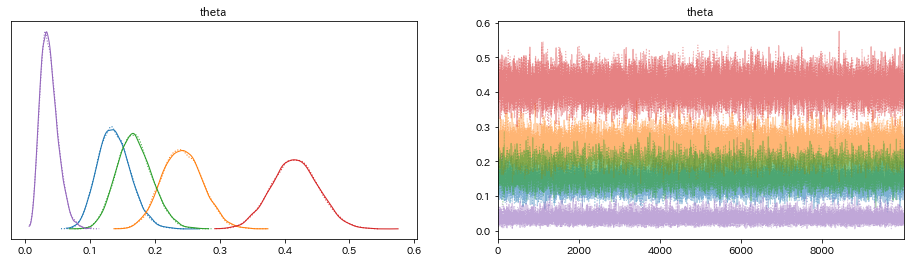

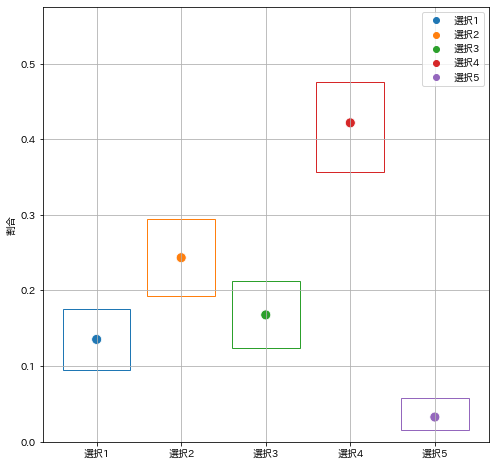

In [171]:
from matplotlib import pyplot as plt
import japanize_matplotlib
import seaborn as sns
import pymc3 as pm
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter('ignore')

#@markdown 値のリスト（例:アンケートの各選択回答数，レビューの星の選択数）を入力
values = (25, 45, 31, 78, 6) #@param {type:"raw"}
n = np.array(values)

#@markdown 重複可（複数回答可）のときだけ総数を入力，そうでないときは"0"
all_size = 0 #@param {type:"integer", min:1}

#@markdown しきい値を入力
threshold = 0.9 #@param {type:"number", min:0.0, max:1.0}

#@markdown サンプルサイズを入力
sample_size = 10000 #@param {type:"integer", min:100, max:1000000}

data = []

print('サンプリング')
with pm.Model() as model:
    if all_size is None or all_size <= 0:
        theta = pm.Dirichlet('theta', a=np.ones(n.shape[0]))
        obs = pm.Multinomial('AB', p=theta, n=n.sum(), observed=n)
    else:
        theta = pm.Uniform('theta', lower=0, upper=1, shape=n.shape[0])
        obs = pm.Binomial('AB', p=theta, n=all_size, observed=n)

    trace = pm.sample(sample_size, chains=2)

    pm.traceplot(trace, figsize=(16, 4))

print()
print()
print('サマリー')

index = [f'選択{i + 1}' for i in range(n.shape[0])]
df = pd.DataFrame(n, index=index, columns=['選択数'])
all_size = df['選択数'].sum() if all_size is None or all_size <= 0 else all_size
df['総数'] = all_size
df = df[['総数', '選択数']]
df['割合'] = df['選択数'] / all_size

df[['HDI下限値', 'HDI上限値']] = [pm.hdi(trace['theta'][:, i], hdi_prob=threshold) for i in range(n.shape[0])]
display(df)

print()
print()
print('誤差')

width_size = round(n.shape[0] * 1.5)
plt.figure(figsize=(width_size, 8))
sns.scatterplot(x=df.index, y=df['割合'], hue=df.index, s=100)
plt.bar(x=df.index, height=df['HDI上限値'] - df['HDI下限値'], bottom=df['HDI下限値'], fill=False, edgecolor=sns.color_palette(n_colors=n.shape[0]))
plt.grid(True)
plt.ylim((0, df['HDI上限値'].max() + 0.1))
plt.show()